In [1]:
import numpy as np
import time
from sklearn import datasets
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from matplotlib import pyplot as plt
from ast import literal_eval

In [3]:
df = pd.read_csv("miem_embeddings.csv",converters={"vectors": literal_eval})
df.head()

,num,title,type,title_lemmatized,vectors
0,1.0,Изучение транспорта заряженных коллоидных част...,НИР,изучение транспорт заряжать коллоидный частица...,"[0.021411802619695663, -0.012915868312120438, ..."
1,2.0,Изучение конвекции Марангони и транспорта колл...,НИР,изучение конвекция марангонь транспорт коллоид...,"[0.03792756423354149, -0.017522942274808884, 0..."
2,3.0,Разработка программного комплекса решения эндш...,НИР,разработка программный комплекс решение эндшпи...,"[0.027339119464159012, -0.0043623377569019794,..."
3,4.0,Программа объединения точек платежей для проти...,Прогр.,программа объединение точка платеж противодейс...,"[0.014935723505914211, -0.006338078528642654, ..."
4,5.0,Антифрод (antifraud),Прогр.,антифрод antifraud,"[0.013650435023009777, -0.00017175286484416574..."


In [4]:
def init(c, data_n):
    A = np.random.random(size=(c, data_n))
    col_sum = np.sum(A, axis=0)
    return A/col_sum


def stepfcm(data, cntr, U, T, expo, a, b, nc, ni):
    mf = np.power(U, expo)
    tf = np.power(T, nc)
    tfo = np.power((1-T), nc)
    cntr = (np.dot(a*mf+b*tf, data).T/np.sum(
        a*mf+b*tf, axis=1).T).T
    dist = distfcm(cntr, data)
    obj_fcn = np.sum(np.sum(np.power(dist, 2)*(a*mf+b*tf), axis=0)) + np.sum(
        ni*np.sum(tfo, axis=0))
    ni = mf*np.power(dist, 2)/(np.sum(mf, axis=0))
    tmp = np.power(dist, (-2/(nc-1)))
    U = tmp/(np.sum(tmp, axis=0))
    tmpt = np.power((b/ni)*np.power(dist, 2), (1/(nc-1)))
    T = 1/(1+tmpt)
    return U, T, cntr, obj_fcn, ni


def distfcm(cntr, data):
    out = np.zeros(shape=(cntr.shape[0], data.shape[0]))
    for k in range(cntr.shape[0]):
        out[k] = np.sqrt(np.sum((np.power(data-cntr[k], 2)).T, axis=0))
    return out


def pfcm(data, c, expo=2, max_iter=1000, min_impro=0.005, a=1, b=4, nc=3):
    obj_fcn = np.zeros(shape=(max_iter, 1))
    ni = np.zeros(shape=(c, data.shape[0]))
    U = init(c, data.shape[0])
    T = init(c, data.shape[0])
    cntr = np.random.uniform(low=np.min(data), high=np.max(data), size=(
        c, data.shape[1]))
    for i in range(max_iter):
        current_cntr = cntr
        U, T, cntr, obj_fcn[i], ni = stepfcm(
                data, cntr, U, T, expo, a, b, nc, ni)
        if i > 1:
            if abs(obj_fcn[i] - obj_fcn[i-1]) < min_impro:
                break
            elif np.max(abs(cntr - current_cntr)) < min_impro:
                break
    return cntr, U

In [5]:
X = np.array(df.vectors.values.tolist())

In [6]:
cntr, U = pfcm(X, 3)

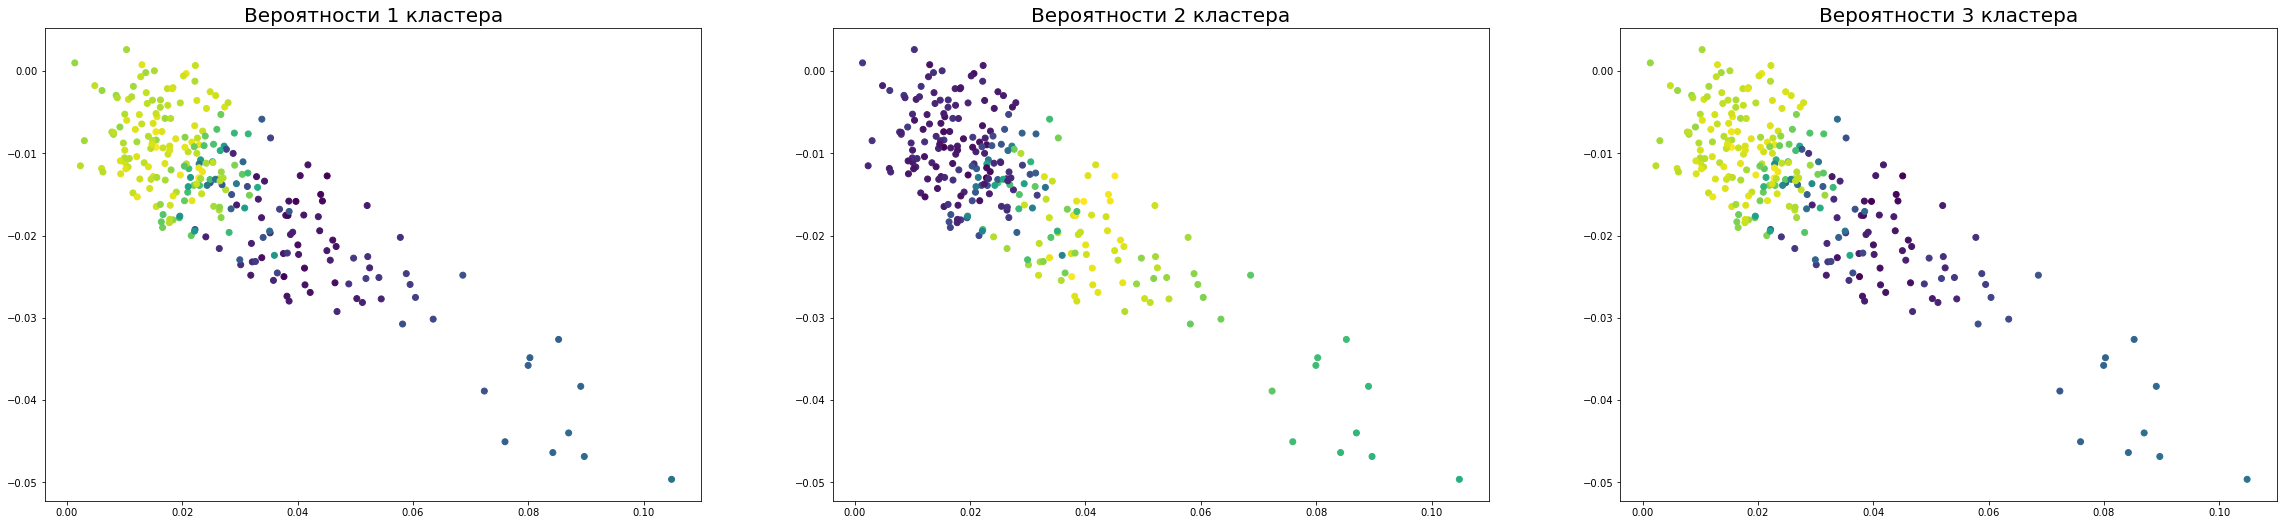

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
plt.subplot(431)
plt.gca().set_title('Вероятности 1 кластера', fontsize = 20)
plt.scatter(X[:, 0], X[:, 1], c=U[0,:])
plt.subplot(432)
plt.gca().set_title('Вероятности 2 кластера', fontsize = 20)
plt.scatter(X[:, 0], X[:, 1], c=U[1,:])
plt.subplot(433)
plt.gca().set_title('Вероятности 3 кластера', fontsize = 20)
plt.scatter(X[:, 0], X[:, 1], c=U[2,:])

In [8]:
from sklearn.metrics import davies_bouldin_score
import numpy as np

def davies_bouldin_sklearn(X, label):
    return davies_bouldin_score(X, label)

def davies_bouldin(X, label):

    n_clusters = len(np.unique(label))
    n_samples = X.shape[0]
    n_features = X.shape[1]

    centroids = np.zeros((n_clusters, n_features))
    for i in range(n_clusters):
        centroids[i, :] = utils.centroid(X[label == i, :])

    sum_score = 0
    for i in range(n_clusters):
        max_score = -1
        for j in range(n_clusters):
            if i == j:
                continue
            compactness  = np.sum(np.sqrt(np.sum(np.square(X[label == i, :] - centroids[i, :]), axis=1))) / X[label == i, :].shape[0]
            compactness += np.sum(np.sqrt(np.sum(np.square(X[label == j, :] - centroids[j, :]), axis=1))) / X[label == j, :].shape[0]
            separability = np.sqrt(np.sum(np.square(centroids[i, :] - centroids[j, :])))
            curr_score = compactness / separability
            if curr_score > max_score:
                max_score = curr_score
        sum_score += max_score
    return (sum_score / n_clusters) ** (-1)

def davies_bouldin_exp(X, label):
    return 0

def davies_bouldin_range(X, labels, k= 1.1583908441240243):
    orig = davies_bouldin(X, labels) 
    orig_logistic = 1 / (1 + np.exp(-k * orig))

    e_val = davies_bouldin_exp(X, labels)
    e_val_logistic = 1 / (1 + np.exp(-k * e_val))
    return (orig_logistic - e_val_logistic) / (1 - e_val_logistic)

def davies_bouldin_shift(X, labels):
    n_clusters = len(np.unique(labels))
    n_samples = X.shape[0]
    n_features = X.shape[1]

    std = np.std(np.sum(np.square(X - utils.centroid(X)), axis=1))

    centroids = np.zeros((n_clusters, n_features))
    for i in range(n_clusters):
        centroids[i, :] = utils.centroid(X[labels == i, :])
    entire_centroid = utils.centroid(X)
    sum_score = 0
    for i in range(n_clusters):
        max_score = -1
        for j in range(n_clusters):
            if i == j:
                continue
            compactness = np.exp(np.sum(np.square(X[labels == i, :] - centroids[i, :])) / (X[labels == i, :].shape[0] * std))
            compactness += np.exp(np.sum(np.square(X[labels == j, :] - centroids[j, :])) / (X[labels == j, :].shape[0] * std))
            separability = (np.sum(np.square(centroids[i, :] - centroids[j, :]))) / std
            invariance_term = np.sum(np.square(X - entire_centroid)) / (n_samples * std)
            curr_score = compactness / (separability * invariance_term)
            if curr_score > max_score:
                max_score = curr_score
        sum_score += max_score
    return (sum_score / n_clusters)  ** (-1)

def davies_bouldin_shift_exp(X, labels):
    return 0


def davies_bouldin_shift_range(X, labels, k=2.4831185988914117):
    orig = davies_bouldin_shift(X, labels)
    orig_logistic = 1 / (1 + np.exp(-k * orig))
    e_val = davies_bouldin_shift_exp(X, labels)
    e_val_logistic = 1 / (1 + np.exp(-k * e_val))
    return (orig_logistic - e_val_logistic) / (1 - e_val_logistic)

def davies_bouldin_shift_range_class(X, labels, k):
    return utils.pairwise_computation_k(X, labels,  k, davies_bouldin_shift_range)

def davies_bouldin_btw(X, labels, k =2.4831185988914117):
    return davies_bouldin_shift_range_class(X, labels, k)

In [9]:
clusters_count, score, scores = find_best_cluster_count(X, 12, pfcm)
res

4
